In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from astropy.io import fits
import numpy as np
import tensorflow as tf
import jax
import jax_cosmo as jc
import sys
sys.path.insert(0,'/Users/dl264294/Desktop/github/howls_step3')
from lenspack.image.transforms import starlet2d
from lenspack.peaks import peaks_histogram
from flowpm.angulat_power import radial_profile, measure_power_spectrum, pixel_size
from howls.peak_counts import get_wavelet_normalization, wavelet_peak_counts, wavelet_l1_norm

Populating the interactive namespace from numpy and matplotlib


In [2]:
data=fits.open('/Users/dl264294/Desktop/github/flowpm/notebooks/kmap.fits')
kmap=data[0].data

In [3]:
# Let's compute the normalization of wavelet scales
wtnorm = get_wavelet_normalization(kmap, nscales=5)
# And derive the bin edges for each scales
bin_edges = np.stack([n*np.linspace(-0.04,0.25,16) for n in wtnorm],axis=0)
# And compute the peak counts
peak_counts = wavelet_peak_counts(kmap, bin_edges=bin_edges)

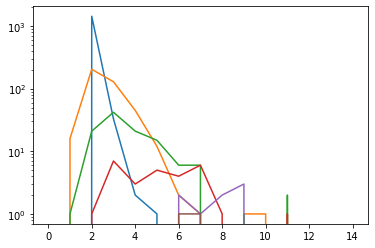

In [4]:
plot(peak_counts[0])
plot(peak_counts[1])
plot(peak_counts[2])
plot(peak_counts[3])
plot(peak_counts[4])
plot(peak_counts[5])
yscale('log')
#savefig('kmap_peak.png',dpi=80)

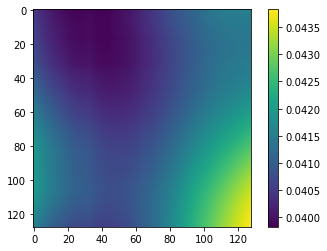

In [5]:
kappa_wt = starlet2d(kmap, nscales=6)
imshow((kappa_wt[-1])); colorbar();

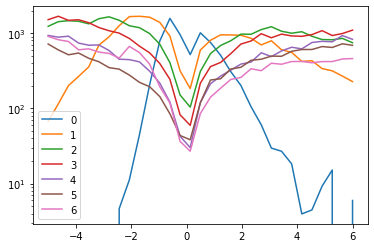

In [6]:
# Let's compute the normalization of wavelet scales
wtnorm = get_wavelet_normalization(kmap, nscales=6)
# And derive the bin edges for each scales
bin_edges = np.stack([n*np.linspace(-0.04,0.25,16) for n in wtnorm],axis=0)

res = wavelet_l1_norm(kmap,wtnorm)
for i in range(len(res)):
    plot(np.linspace(-5,6,31), res[i][:], label='%d'%i)
yscale('log')
legend()

In [7]:
#Let's compute the same for mnu map

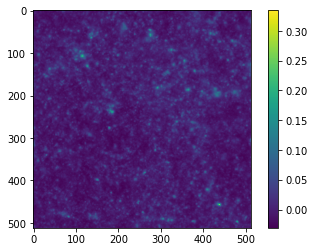

In [8]:
mnu_map = np.load('/Users/dl264294/Downloads/mnu_map.npy')
imshow(mnu_map)
colorbar()

In [9]:
wtnorm_mnu = get_wavelet_normalization(mnu_map, nscales=6)
bin_edges_mnu = np.stack([n*np.linspace(-0.04,0.25,16) for n in wtnorm_mnu],axis=0)
peak_counts_mnu = wavelet_peak_counts(mnu_map, bin_edges=bin_edges_mnu)

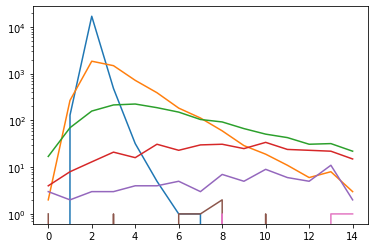

In [10]:
plot(peak_counts_mnu[0])
plot(peak_counts_mnu[1])
plot(peak_counts_mnu[2])
plot(peak_counts_mnu[3])
plot(peak_counts_mnu[4])
plot(peak_counts_mnu[5])
plot(peak_counts_mnu[6])
yscale('log')

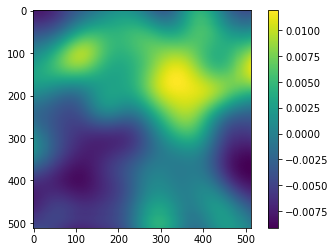

In [11]:
kappa_wt_mnu = starlet2d(mnu_map, nscales=6)
imshow((kappa_wt_mnu[-1])); colorbar();

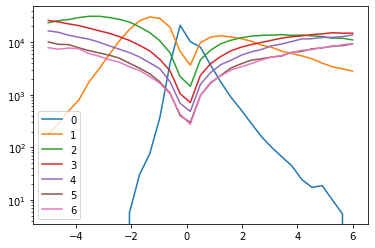

In [12]:
wtnorm_mnu = get_wavelet_normalization(mnu_map, nscales=6)
# And derive the bin edges for each scales
bin_edges_mnu = np.stack([n*np.linspace(-0.04,0.25,16) for n in wtnorm_mnu],axis=0)

res = wavelet_l1_norm(mnu_map,wtnorm_mnu)

for i in range(len(res)):
    plot(np.linspace(-5,6,31), res[i][:], label='%d'%i)
yscale('log')
legend()

In [13]:
#we need to rescale mnumap and get a lower pixel resolution 
mnu_map_new = mnu_map[:,:,tf.newaxis]
mnu_map_rescale= tf.image.resize(mnu_map_new,[128,128],method='gaussian')
mnumap_new=tf.squeeze(mnu_map_rescale)

In [14]:
wtnorm_mnumap = get_wavelet_normalization(mnumap_new, nscales=6)
bin_edges_mnumap = np.stack([n*np.linspace(-0.04,0.25,16) for n in wtnorm_mnumap],axis=0)
peak_counts_mnumap = wavelet_peak_counts(mnumap_new, bin_edges=bin_edges_mnumap)

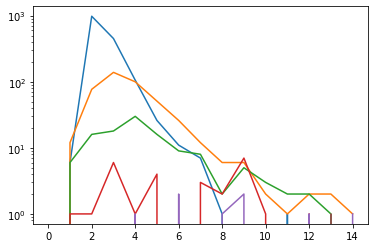

In [15]:
plot(peak_counts_mnumap[0])
plot(peak_counts_mnumap[1])
plot(peak_counts_mnumap[2])
plot(peak_counts_mnumap[3])
plot(peak_counts_mnumap[4])
plot(peak_counts_mnumap[5])
plot(peak_counts_mnumap[6])
yscale('log')

In [16]:
#Let's compute the power spectrum from maps and the theoretical angular power spectrum

In [17]:
ell, ps_example = measure_power_spectrum(mnumap_new, 5.,128)
ell_,ps_example_ = measure_power_spectrum(mnu_map, 5.,512)

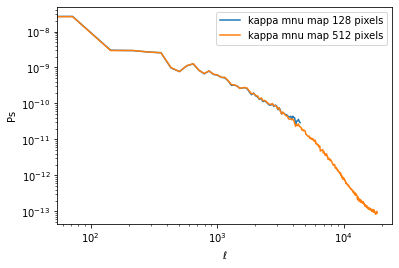

In [18]:
loglog(ell, ps_example, label='kappa mnu map 128 pixels')
loglog(ell_, ps_example_, label='kappa mnu map 512 pixels')
xlabel('$\ell$')
ylabel('Ps')
legend()

In [19]:
#let's compute the  theoretical angular power spectrum

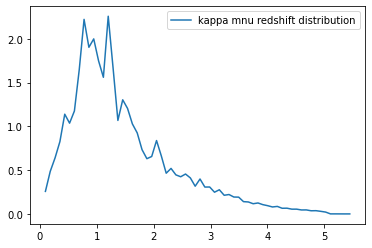

In [20]:
#let's compute the redshift ditribution for mnumap
z_array = np.load('/Users/dl264294/Desktop/github/flowpm/notebooks/z_array.npy') #redshift array
pz_array=np.load('/Users/dl264294/Desktop/github/flowpm/notebooks/pz_array.npy') #redshift histogram
nz_smnu=jc.redshift.kde_nz(z_array, pz_array,bw=0.011)                           #redshift distribution
nzs_mnu=[nz_smnu]
plot(z_array, nz_smnu(z_array),label='kappa mnu redshift distribution')
legend()

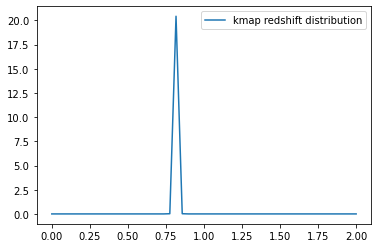

In [21]:
#let's compute the redshift ditribution from our k-map
z = linspace(0,2)                            #redshift array
pz = zeros_like(z)                           #redshift histogram
pz[20] =1                                    #redshift histogram
nzs_s=jc.redshift.kde_nz(z, pz,bw=0.011)     #redshift distribution
nzs = [nzs_s]
plot(z, nzs_s(z),label='kmap redshift distribution')
legend()

In [22]:
probes = [ jc.probes.WeakLensing(nzs_mnu, sigma_e=0.26) ]
probes_kmap=[ jc.probes.WeakLensing(nzs, sigma_e=0.26) ]

In [23]:
elle = np.logspace(1,5) # Defines a range of \ell
cosmo_jc = jc.Planck15()
# And compute the data vector
cls = jc.angular_cl.angular_cl(cosmo_jc, elle, probes)
cls_kmap = jc.angular_cl.angular_cl(cosmo_jc, elle, probes_kmap)

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


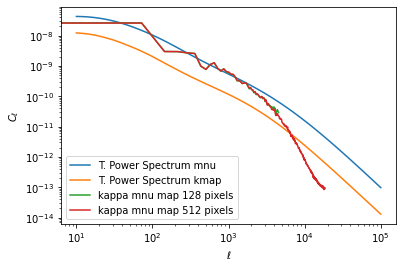

In [24]:
loglog(elle, cls[0],label='T. Power Spectrum mnu')
loglog(elle, cls_kmap[0],label='T. Power Spectrum kmap')
loglog(ell, ps_example, label='kappa mnu map 128 pixels')
loglog(ell_, ps_example_, label='kappa mnu map 512 pixels')
ylabel(r'$C_\ell$')
xlabel(r'$\ell$')
legend()
#title('nc=128c')
